In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR,LinearSVR
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-car-dataset-ford-and-mercedes/cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/focus.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/audi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/toyota.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/skoda.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/ford.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/vauxhall.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/bmw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/vw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/hyundi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean focus.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/merc.csv


# Exploring the Data

For the sake of simplicity, we go ahead with only the 'Ford and Mercedes C class cars' in order to limit our data size. Note that SVM does not scale very well when the number of samples are large (>10k), this is because the training complexity of SVM is very high.

In [2]:
df=pd.read_csv('/kaggle/input/used-car-dataset-ford-and-mercedes/cclass.csv')

We have a total of 7 columns, with our target column being price that we need to predict. There are a number of categorical columns that we are required to encode as well.

In [3]:
df.head()

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3899 entries, 0 to 3898
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         3899 non-null   object 
 1   year          3899 non-null   int64  
 2   price         3899 non-null   int64  
 3   transmission  3899 non-null   object 
 4   mileage       3899 non-null   int64  
 5   fuelType      3899 non-null   object 
 6   engineSize    3899 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 213.4+ KB


Great! We don't have any null values for the columns...

In [5]:
df.isna().any()

model           False
year            False
price           False
transmission    False
mileage         False
fuelType        False
engineSize      False
dtype: bool

In [6]:
df.corr()['price'].sort_values()

mileage      -0.679655
engineSize    0.373798
year          0.674424
price         1.000000
Name: price, dtype: float64

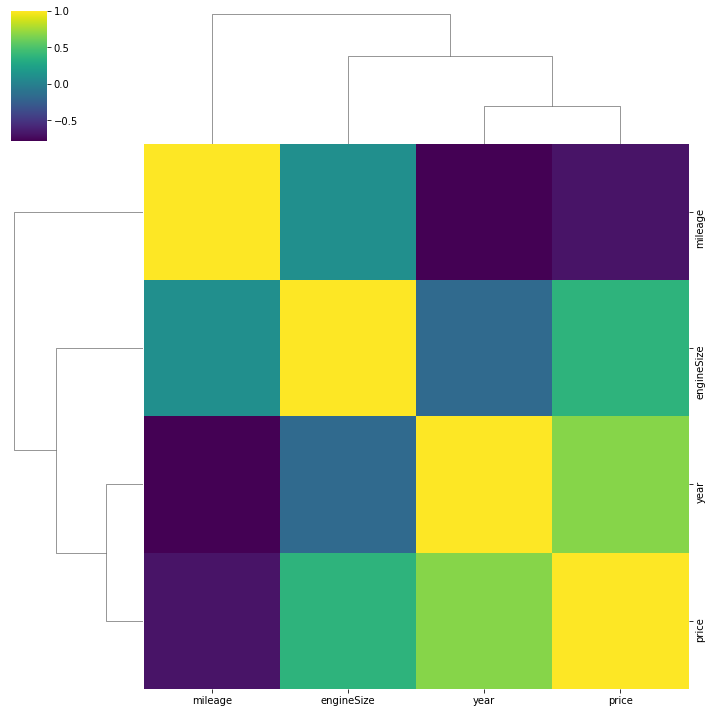

In [7]:
sns.clustermap(df.corr(),cmap='viridis')

It is also visible that the features have a high correlation with the price column which can be of significan to us, mainly because we have only 3 feature columns.

In [8]:
years=df['year'].value_counts().sort_values()

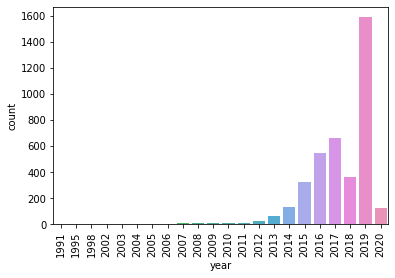

In [9]:
sns.countplot(data=df,x=df['year'])

plt.xticks(rotation=90);

Most of our data is relatively new and the vast majority of cars are from the year 2019. The oldest car is from 1951, and the number of cars doesnt really increase uptil 2013. 

<AxesSubplot:xlabel='year', ylabel='price'>

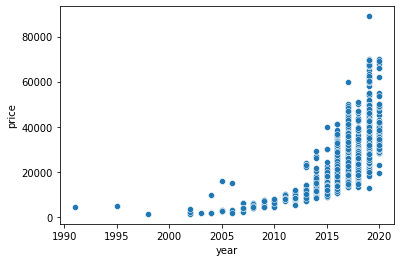

In [10]:
sns.scatterplot(data=df,x='year',y='price')

As the years progress, so do the prices of the cars which are second hand. This is because newer cars tend to have higher prices simply because they are used less. Notice how the cars with larger engines also always tend to cost more.

# Feature Encoding

We can directly go ahead and encode all the categorical classes with get_dummies(). 

In [11]:
df=pd.get_dummies(df, columns=["model","year","transmission","fuelType"],drop_first=True)
df.head()

,price,mileage,engineSize,year_1995,year_1998,year_2002,year_2003,year_2004,year_2005,year_2006,...,year_2017,year_2018,year_2019,year_2020,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,30495,1200,2.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,29989,1000,1.5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,37899,500,2.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,30399,5000,2.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,29899,4500,2.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


# Theory On SVM  
Support Vector Machine (SVM) is a supervised machine learning algorithm that can be used for classification or regression tasks. The idea behind SVM is to find the best boundary or decision surface that separates the data into different classes.  
The boundary is chosen in such a way that it maximizes the margin, which is the distance between the boundary and the closest data points from each class, also known as support vectors. 

SVMs can be used for both linear and non-linear classification. In the case of linear classification, the decision boundary is a straight line or hyperplane. However, when the data is not linearly separable, we can use a technique called the kernel trick to transform the data into a higher dimensional space where it becomes linearly separable. Common kernel functions include the polynomial kernel and the radial basis function (RBF) kernel.  

Now that we've gotten a good idea about Support Vectors, lets go ahead and create the test and train split and fit our model!

In [12]:
X=df.drop('price',axis=1)
y=df['price']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [14]:
base_model = SVR()
base_model.fit(X_train,y_train)

SVR()

In [15]:
y_test.mean()

23444.048717948717

In [16]:
base_preds = base_model.predict(X_test)


MEA = mean_absolute_error(y_test,base_preds)
RMSE = np.sqrt(mean_squared_error(y_test,base_preds))
print("The RMSE is "+str(RMSE))
print("The MEA is "+str(MEA))

The RMSE is 8936.944009043626
The MEA is 6551.932766674952


We arrive at a respectable RMSE and MEA for our error metrics. However, if we look further into the parameters and choose appropriate values for them we will ge

# SVR Parameters  
The scikit-learn library provides several parameters that can be used to control the behavior of the SVM algorithm. Some of the most commonly used parameters include:

* kernel: The kernel function to be used. Common choices include 'linear', 'poly', 'rbf', and 'sigmoid'.
* C: The regularization parameter. Larger values of C will result in a smaller margin but a more accurate decision boundary. Smaller values of C will result in a larger margin but a less accurate decision boundary.
* degree: The degree of the polynomial kernel function, if that is the chosen kernel.
* gamma : The gamma parameter of the radial basis function (RBF) kernel. Larger values of gamma will result in a decision boundary that is more closely fit to the training data, while smaller values will result in a decision boundary that is more smooth.

For our scenario, we wish to only modify and try multiple different C values and degrees for hyperparameter optimization.

In [17]:
param_grid = {'C':[0.5,1,1.25],
             'kernel':['poly'],
              'degree':[2,3]
              }

In [18]:
# setting n_jobs as -1 so that all cores are used. SVM takes quite a while to create the fits with GridSearchCV
svr = SVR()
grid = GridSearchCV(svr,param_grid=param_grid, n_jobs = -1)

grid.fit(X_train,y_train)

GridSearchCV(estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.5, 1, 1.25], 'degree': [2, 3],
                         'kernel': ['poly']})

Lets see what parameters our model chose...

In [19]:
grid.best_params_

{'C': 1.25, 'degree': 2, 'kernel': 'poly'}

In [20]:
grid_preds = grid.predict(X_test)
MEA = mean_absolute_error(y_test,grid_preds)
RMSE = np.sqrt(mean_squared_error(y_test,grid_preds))
print("MEA is "+ str(MEA))
print("RMSE is "+ str(RMSE))

MEA is 5627.93821305898
RMSE is 8076.05189126961


Yaay! Our scores improved! Further optimization would yield an even better prediction. But for now, lets leave it as is. SVM is a really powerful tool and very versatile for small datasets which have unusual types of feature signals which cant be captured by ordinary models.